# APF test

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from swarm_prm.solvers.swarm_prm.macro.gaussian_prm import *
from swarm_prm.envs.map import Map, Obstacle 
from swarm_prm.envs.instance import Instance

roadmap = Map(100, 100)
pos = np.array([50, 50])
obstacles  = [
    Obstacle(None, "POLYGON", [(40, 0), (40, 40), (80, 40), (80, 0)]),
    Obstacle(None, "POLYGON", [(40, 100), (40, 50), (80, 50), (80, 100)])
]
num_samples = 500
for obs in obstacles:
    roadmap.add_obstacle(obs)
# fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

# Agent config
num_agent = 10
agent_radius = 1
sampling_method = "GAUSSIAN_SAMPLING"
#sampling_method = "SWARMPRM_SAMPLING"
TEST_CVAR = False


# Curated test instance
starts = np.array([[10, 10], [10, 90]])
goals = np.array([[90, 90], [90, 10]])

starts_weight = np.array([.5, .5])
goals_weight = np.array([.5, .5])

g_starts = [GaussianGraphNode(start, np.identity(2)*10) for start in starts]
g_goals = [GaussianGraphNode(goal, np.identity(2)*10) for goal in goals]

instance = Instance(roadmap, g_starts, g_goals, starts_weight, goals_weight, num_agent)

gaussian_prm = GaussianPRM(instance, num_samples)
gaussian_prm.sample_free_space(sampling_strategy="UNIFORM_HALTON")
gaussian_prm.load_instance()
gaussian_prm.build_roadmap(roadmap_method="TRIANGULATION", collision_check_method="CVAR")
# gaussian_prm.visualize_roadmap("test_map")
# gaussian_prm.visualize_g_nodes("test_g_nodes")


from swarm_prm.solvers.swarm_prm.macro.teg_nx import TEGGraph_NX
teg_graph= TEGGraph_NX(gaussian_prm, agent_radius, target_flow=num_agent)
max_flow, flow_dict, timestep, teg, restricted_edges  = teg_graph.find_earliest_timestep()
print("max flow", max_flow)
print("timestep", timestep)

assert max_flow is not None, "Unable to find solution within the given timesteps"

simple_paths, gaussian_paths = gaussian_prm.get_solution(flow_dict, timestep, num_agent)

timestep: 0 max_flow: 0
timestep: 1 max_flow: 0
timestep: 2 max_flow: 0
timestep: 3 max_flow: 0
timestep: 4 max_flow: 0
timestep: 5 max_flow: 0
timestep: 6 max_flow: 0
timestep: 7 max_flow: 0
timestep: 8 max_flow: 0
timestep: 9 max_flow: 0
timestep: 10 max_flow: 0
timestep: 11 max_flow: 0
timestep: 12 max_flow: 0
timestep: 13 max_flow: 0
timestep: 14 max_flow: 0
timestep: 15 max_flow: 0
timestep: 16 max_flow: 0
timestep: 17 max_flow: 0
timestep: 18 max_flow: 0
timestep: 19 max_flow: 0
timestep: 20 max_flow: 0
timestep: 21 max_flow: 0
timestep: 22 max_flow: 0
timestep: 23 max_flow: 0
timestep: 24 max_flow: 0
timestep: 25 max_flow: 0
timestep: 26 max_flow: 0
timestep: 27 max_flow: 0
timestep: 28 max_flow: 0
timestep: 29 max_flow: 2
timestep: 30 max_flow: 5
timestep: 31 max_flow: 5
timestep: 32 max_flow: 7
timestep: 33 max_flow: 10
max flow 10
timestep 34


In [3]:
print(simple_paths[0][0])

[10 10]


## APF

Early Termination at macro timestep 13
Found solution


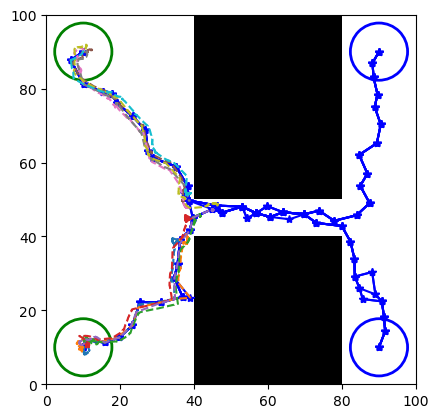

In [4]:
from matplotlib import pyplot as plt
from swarm_prm.solvers.swarm_prm.micro.apf import APFSingleStepSolver

apf_solver = APFSingleStepSolver(roadmap, simple_paths, 1, timestep, 
                                 step_size=0.1, max_timestep_iter=1000, 
                                 ordering_strategy="GEOMETRY", 
                                 attract_coeff=0.3, repel_coeff=0.1,
                                 reach_dist=3)
apf_path = apf_solver.get_solution()

fig, ax = instance.visualize()

# Visualize 
# apf_solver.animate_solution(fig, ax)
for path in simple_paths:
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '-*', label='Path', color='blue')
# 
cmap = plt.get_cmap("tab10")
# 
for i, path in enumerate(apf_path):
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '--', label='Path', color=cmap(i))

In [5]:
print(len(apf_path[0]))

10656


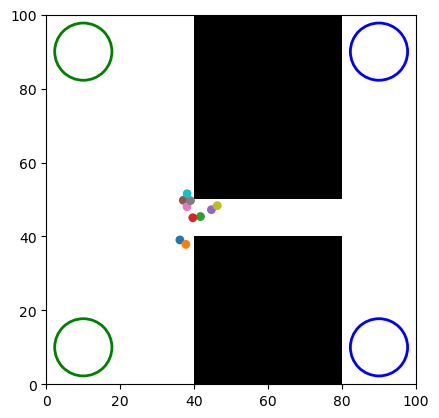

In [6]:
def animate_solution(fig, ax, speed):
    """
        Visualize solution trajectory provided instance
    """
    
    agents = []
    def init():
        for agent in agents:
            agent.remove()
        agents.clear()
        return []

    def update(frame):
        idx = frame * speed
        for agent in agents:
            agent.remove()
        agents.clear()
        cmap = plt.get_cmap("tab10")
        locs = [traj[idx] for traj in apf_path]
        for i, loc in enumerate(locs):
            agent = ax.add_patch(Circle(loc, radius=agent_radius, color=cmap(i%10)))
            agents.append(agent)
        return agents

    anim = FuncAnimation(fig, update, frames=len(apf_path[0]) // speed, 
                         init_func=init, blit=True, interval=100)
    anim.save("apf_solution.gif", writer='pillow', fps=6)

fig, ax = instance.visualize()
animate_solution(fig, ax, 50)